In [ ]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.9", "Referer": "https://www.ewg.org/tapwater/", "Connection": "keep-alive"}



from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

'from bs4 import BeautifulSoup\nimport requests\nheaders = {\'User-Agent\': \'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3\'}\nheaders = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.9", "Referer": "https://www.ewg.org/tapwater/", "Connection": "keep-alive"}\n\n\n\nfrom selenium.webdriver.edge.options import Options\n\nedge_options = Options()\n#edge_options.add_argument(\'--headless\')\nedge_options.add_argument("--disable-images")  # Disable images\nedge_options.add_argument("--disable-javascript")  # Disable JavaScript\nedge_options.add_argument("--disable-plugins")  # Disable plugins\nedge_options.add_argument("--disable-extensions")  # Disable extensions\nedge_options.add_argument("--blink-settings=imagesEnabled=false")  

In [ ]:
url='https://www.youtube.com/@DailyDoseOfInternet/videos'
driver.get(url)

In [ ]:
all_hrefs=[]
count_same=0

while True:
    elements=driver.find_elements(By.CSS_SELECTOR,'ytd-rich-item-renderer a[id="thumbnail"][class="yt-simple-endpoint inline-block style-scope ytd-thumbnail"]')
    prev_len=len(all_hrefs)

    hrefs=[e.get_attribute('href') for e in elements]
    all_hrefs=list(set(all_hrefs+hrefs))

    if len(all_hrefs)==prev_len:
       count_same+=1
    else:
        count_same=0


    if count_same==5: 
        break

    #driver.execute_script("window.scrollBy(0, 500);")
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")


    time.sleep(3)

    print(len(all_hrefs), count_same, end='\r')

In [ ]:
#pickle.dump(all_hrefs, open('all_urls.pickle','wb'))
all_hrefs=pickle.load( open('all_urls.pickle','rb'))
len(all_hrefs)

In [ ]:
all_data={}
driver.get('https://commentviewer.com/')

for i, href in enumerate(all_hrefs,start=1):
    try:
        search_bar=driver.find_element(By.CSS_SELECTOR, 'input[id="enterID"]')
        time.sleep(1)
        search_bar.send_keys(href)
        search_bar.send_keys(Keys.ENTER)
        time.sleep(1)
        info=WebDriverWait(driver,10).until(expected_conditions.visibility_of_element_located((By.CSS_SELECTOR, 'div[class="col-sm"]'))).text
        all_data[href]=info
        time.sleep(1)
        driver.get('https://commentviewer.com/')
        time.sleep(1)
    except:
        all_data[href]=None

    print(f'{i}/{len(all_hrefs)}',end='\r')



In [99]:
#pickle.dump(all_data, open('all_data.pickle','wb'))
all_data=pickle.load( open('all_data.pickle','rb'))

In [100]:
all_data={k:v.split('\n') for k, v in all_data.items()}

In [101]:
df=pd.DataFrame(all_data).T

In [102]:
df.columns=['Title', 'Channel', 'Views', 'Likes', 'Date Published', 'Comments']

In [103]:
df=df.drop(columns='Channel')

In [ ]:
df['Views']=df['Views'].apply(lambda x:x.asplit('views')[0].replace(',','')).apply(pd.to_numeric)
df['Likes']=df['Likes'].apply(lambda x:x.split('views')[0].replace(',','')).apply(pd.to_numeric)
df['Date Published']=df['Date Published'].apply(lambda x:x.split(',')[0].split(':')[-1].strip())
df['Comments']=df['Comments'].apply(lambda x:x.split('comments')[0].replace(',','')).apply(pd.to_numeric)

In [109]:
df.to_csv('DDOI.csv',index=False)

In [110]:
df=pd.read_csv('DDOI.csv')

In [111]:
df

,Title,Views,Likes,Date Published,Comments
0,The Worst Proposal Ever,"4,036,076 views","172,294",2024-04-14 00:07:02,"6,190 comments"
1,Drying a Car with Water,"7,913,778 views","312,791",2022-07-08 00:01:25,"6,429 comments"
2,He Stepped Right Into It,"5,398,339 views","228,004",2023-02-14 02:10:08,"8,232 comments"
3,This Broke His Brain,"10,319,345 views","377,846",2022-10-17 23:59:29,"11,551 comments"
4,They Didn't Think This Through,"2,823,859 views","97,915",2025-07-12 21:05:43,"2,991 comments"
...,...,...,...,...,...
762,His Last Day on the Job,"1,745,288 views","76,494",2025-09-01 23:35:12,"2,890 comments"
763,Random Tire Hits House At High Speed,"22,237,124 views","551,060",2020-09-04 00:15:54,"32,350 comments"
764,Driving While On Fire,"7,905,401 views","218,712",2019-09-10 00:51:57,"11,634 comments"
765,Car Crashes into Pool,"3,302,621 views","144,863",2024-05-25 03:34:46,"3,866 comments"


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

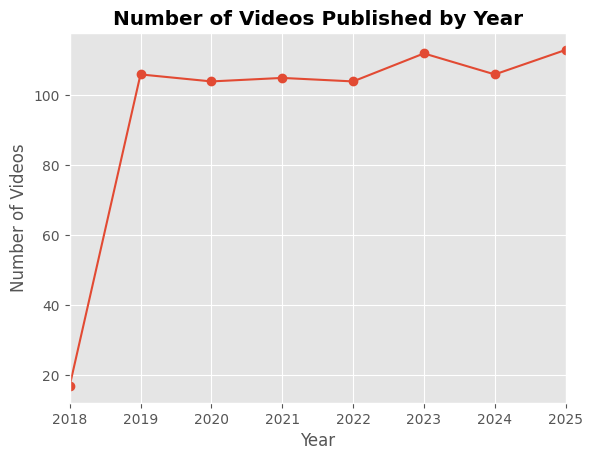

In [6]:
grouped=df.groupby(df['Date Published'].dt.to_period('Y'))['Title'].count()
grouped.plot.line(marker='o')
plt.title('Number of Videos Published by Year',fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Videos')
plt.show()

In [7]:
df=df.sort_values('Date Published',ascending=True)
df['Days Passed']=(df['Date Published'] - df['Date Published'].shift(1)).apply(
    lambda x: int(str(x).split(' day')[0]) if isinstance(x, pd.Timedelta) else None
)

C:\Users\berid\AppData\Local\Temp\ipykernel_5152\635062915.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouped.index, rotation=90,size=6,fontweight='bold')
C:\Users\berid\AppData\Local\Temp\ipykernel_5152\635062915.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['5M', '10M', '15M', '20M', '25M', '30M'])


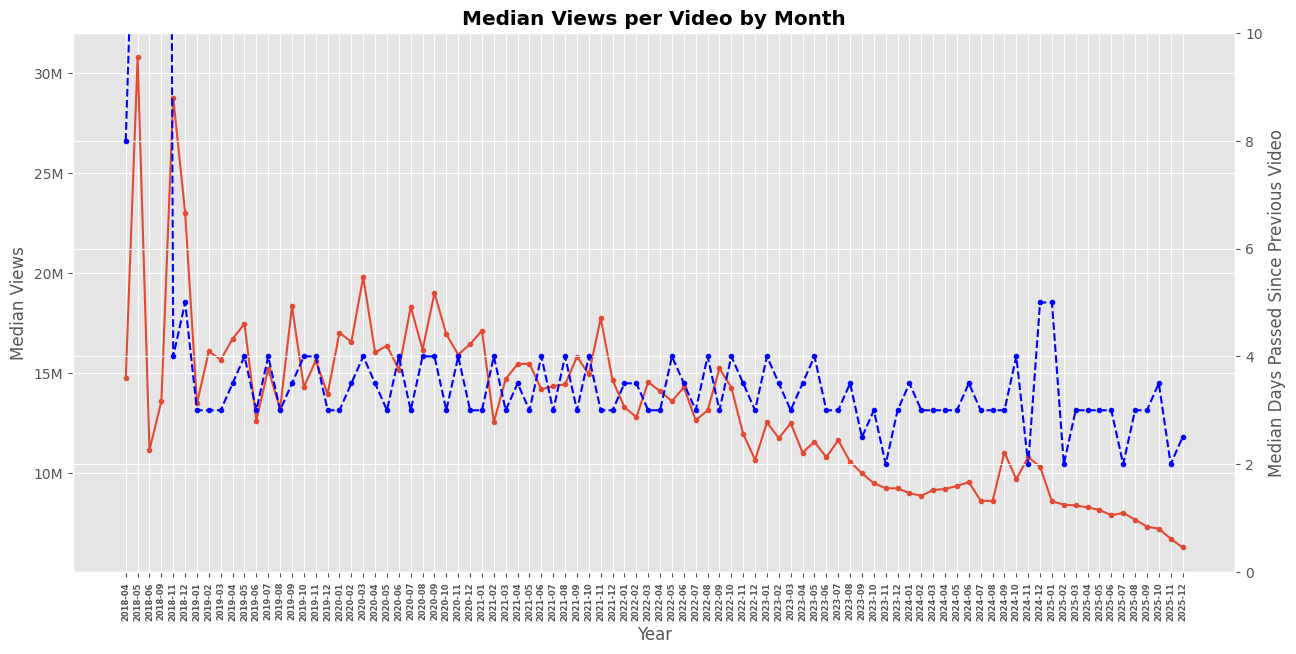

In [13]:
grouped=df.groupby(df['Date Published'].dt.to_period('M')).agg({'Views':'median', 'Days Passed':'median'})

fig, ax1 = plt.subplots(figsize=(15,7))

ax1.plot(grouped.index.astype(str), grouped['Views'], marker='.')
ax2 = ax1.twinx()
ax2.plot(grouped.index.astype(str), grouped['Days Passed'], marker='.', linestyle='--',color='blue')

ax1.set_title('Median Views per Video by Month', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Views')
ax2.set_ylabel('Median Days Passed Since Previous Video')

ax2.set_ylim(0,10)
ax1.set_xticklabels(grouped.index, rotation=90,size=6,fontweight='bold')
#ax1.set_yticks([0.5, 1, 1.5])
ax1.set_yticklabels(['5M', '10M', '15M', '20M', '25M', '30M'])

plt.show()

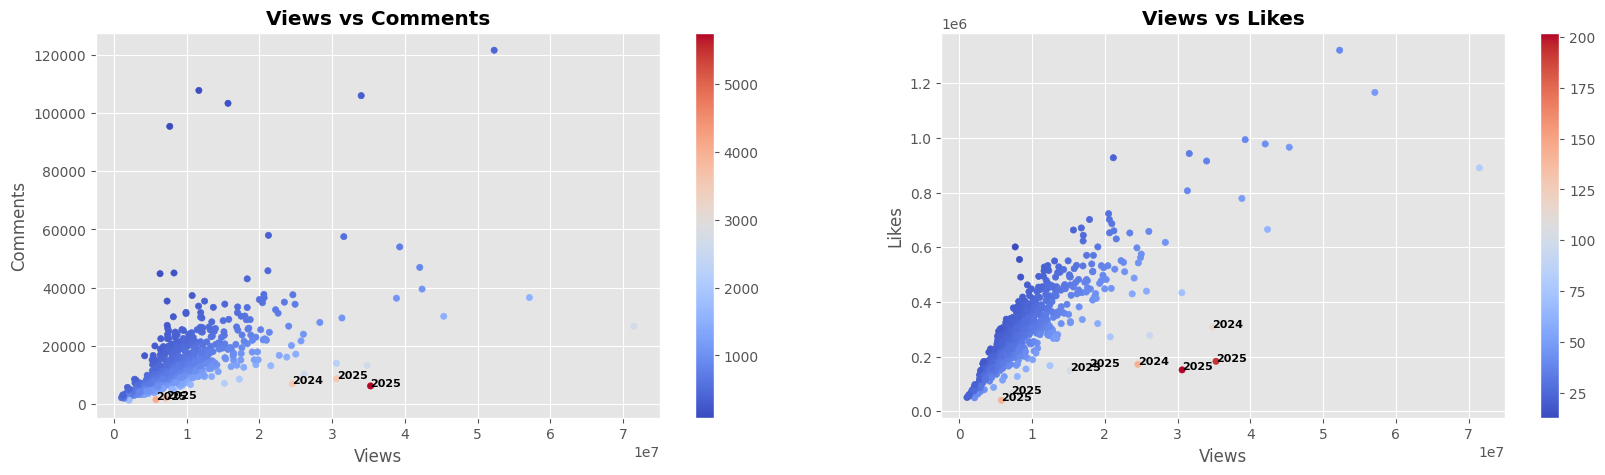

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
df.plot.scatter(ax=ax1, x='Views', y='Comments', c=df['Views']/df['Comments'],cmap='coolwarm')
df.plot.scatter(ax=ax2, x='Views', y='Likes', c=df['Views']/df['Likes'],cmap='coolwarm')

ax1.set_title('Views vs Comments',fontweight='bold')
ax2.set_title('Views vs Likes',fontweight='bold')


for i in range(len(df)):
    if (df['Views']/df['Comments']).iloc[i]>=3000:
        ax1.text(df['Views'].iloc[i], df['Comments'].iloc[i], df['Date Published'].dt.year.iloc[i],size=8,fontweight='bold')

for i in range(len(df)):
    if (df['Views']/df['Likes']).iloc[i]>=100:
        ax2.text(df['Views'].iloc[i], df['Likes'].iloc[i], df['Date Published'].dt.year.iloc[i],size=8,fontweight='bold')

plt.show()